In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.optim as optim
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import PIL
from sklearn.model_selection import train_test_split
import zipfile

Hides warnings (this is used because we use a `num_workers` parameter above the recommended value):

In [31]:
import warnings
warnings.filterwarnings('ignore')

We first need to extract the data. This code is commented out after the extraction.

In [32]:
"""
covid_zip = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets/Dataset 4_ COVID-19 Radiografia de Pulmões-20210324T201112Z-001.zip'

with zipfile.ZipFile(covid_zip, 'r') as zip:
    zip.extractall('/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets')    
    zip.close()
"""

"\ncovid_zip = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets/Dataset 4_ COVID-19 Radiografia de Pulmões-20210324T201112Z-001.zip'\n\nwith zipfile.ZipFile(covid_zip, 'r') as zip:\n    zip.extractall('/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets')    \n    zip.close()\n"

Check out some of the images:

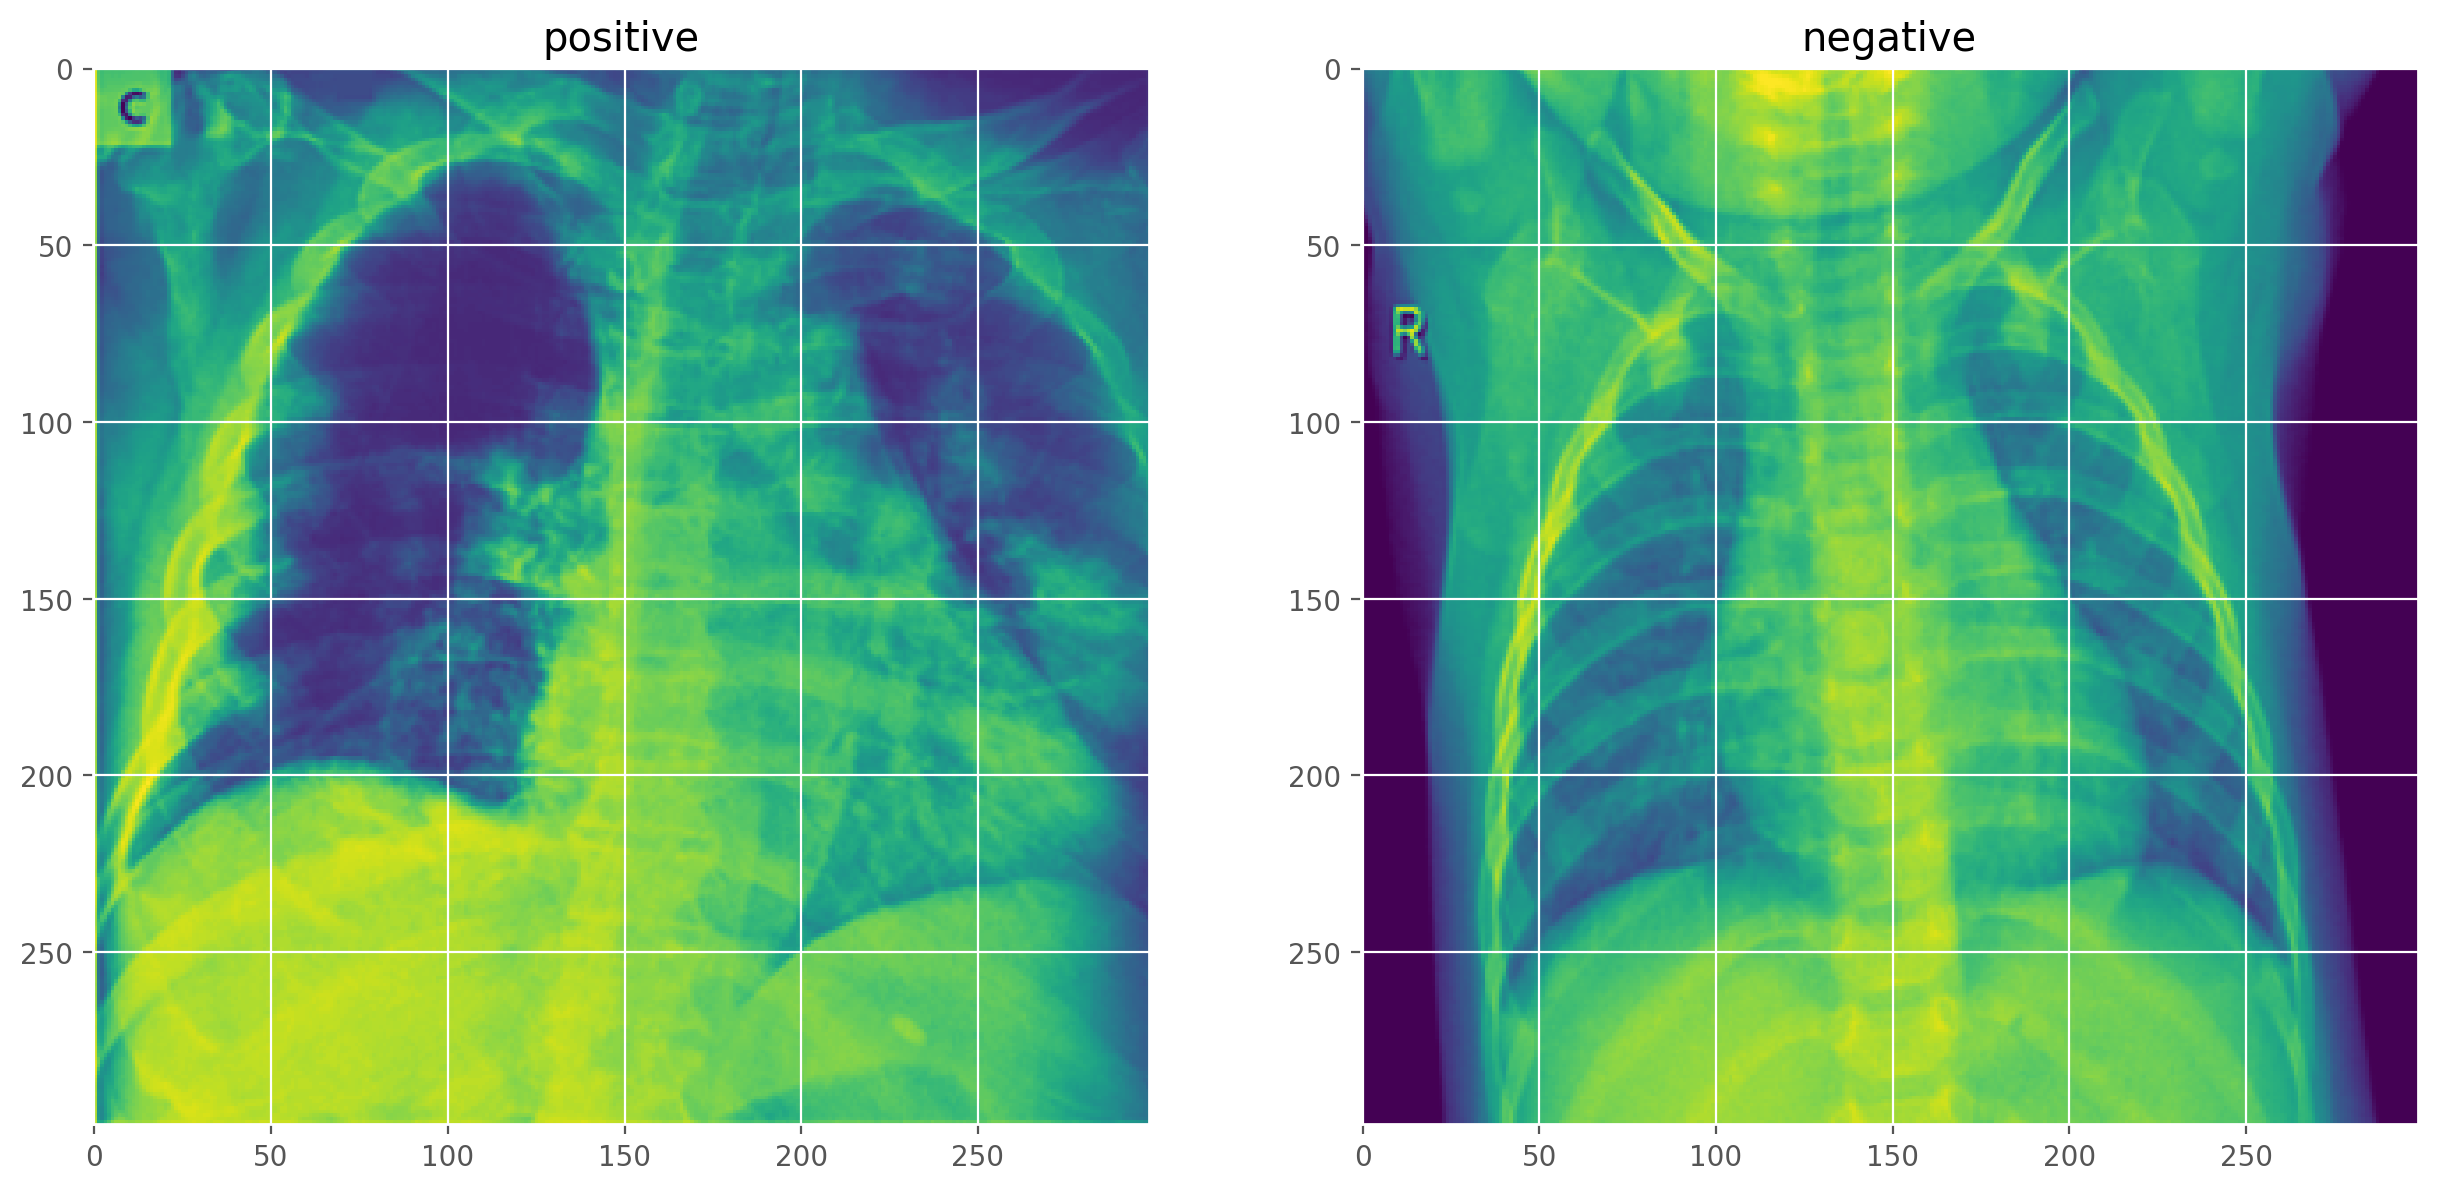

In [33]:
negative_example = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets/Dataset 4_ COVID-19 Radiografia de Pulmões/COVID-19 Negativo/Normal-97.png'
positive_example = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets/Dataset 4_ COVID-19 Radiografia de Pulmões/COVID-19 Positivo/COVID-8.png'

positive_example = PIL.Image.open(positive_example)
negative_example = PIL.Image.open(negative_example)

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
axs[0].imshow(positive_example)
axs[0].set_title('positive')

axs[1].imshow(negative_example)
axs[1].set_title('negative')
plt.show()

Explore some info related to the dataset:

(299, 299)
(43, 251)


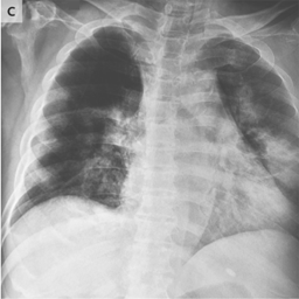

In [34]:
print(positive_example.size)
print(positive_example.getextrema())
positive_example

Images are 299x299 and have pixel values that range from 0 to 255.

Due to the directory structure of the dataset, we can easily create an `ImageFolder` based dataset:

In [35]:
class CovidDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):            
        data = dataset[idx][0]
        label = dataset[idx][1]
        
        data = self.transform(data)
        label = torch.tensor(label)

        return data, label

    def __len__(self):
        return len(self.dataset)

We can define our transforms as:

In [36]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(3),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(224),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

eval_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(224),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

Creating a dataset with all images:

In [37]:
dataset = ImageFolder('/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets/Dataset 4_ COVID-19 Radiografia de Pulmões')
dataset

Dataset ImageFolder
    Number of datapoints: 13827
    Root location: /content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/Datasets/Dataset 4_ COVID-19 Radiografia de Pulmões

It's important for us to get the map between label and class:

In [38]:
print(dataset.class_to_idx)

{'COVID-19 Negativo': 0, 'COVID-19 Positivo': 1}


We can also check the number of images in every class on the `ImageFolder` dataset.

In [39]:
np.unique(dataset.targets, return_counts=True)

(array([0, 1]), array([10212,  3615]))

We have an overwhelming majority of Negatives, which can be a problem when it comes to our training data. In order to handle this problem we'll use PyTorch's `WeightedRandomSampler`:

In [40]:
class_sample_counts = np.unique(dataset.targets, return_counts=True)[1]
class_sample_counts

array([10212,  3615])

In [41]:
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
print(weights)
print(weights.round())

samples_weights = weights[dataset.targets]
print(samples_weights)
print(samples_weights.size())

sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

tensor([9.7924e-05, 2.7663e-04])
tensor([0., 0.])
tensor([9.7924e-05, 9.7924e-05, 9.7924e-05,  ..., 2.7663e-04, 2.7663e-04,
        2.7663e-04])
torch.Size([13827])


Splitting the data into train, validation and test sets:

In [42]:
train_dataset = CovidDataset(dataset, train_transform)
val_dataset = CovidDataset(dataset, eval_transform)
test_dataset = CovidDataset(dataset, eval_transform)

In [43]:
train_size = 0.8

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

In [44]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

11061
1383
1383


Looks like a resonable split given the amount of data that we have!

Now to create the `DataLoader`s:

In [45]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64, num_workers=8)
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=64, num_workers=4)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=64, num_workers=2)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}

Now that we can use our data in a meaningful way for training, we can start creating the models!

We'll use a transfer learning technique, using a Resnet50 architecture as our pre-trained network: (we must also define the device that we'll use for training)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training

In [ ]:
model = models.resnet50(pretrained=True)

We must modify the network's last layer in order for it to output a value that can be used in binary classification:

In [ ]:
num_ftrs = model.fc.in_features # gets last layer's features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 2)) # changes output to 2

model = model.to(device) # pass model to GPU

Nice, now that we have both the model and our data ready, we just need to define our training loop!

In [ ]:
# hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
save_path = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/model.pt'
history_path = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/history.pt'
epochs = 10

# training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

since = time.time()

for epoch in range(epochs):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        loop = tqdm(dataloaders[phase], total=len(dataloaders[phase]), position=0, leave=True)
        for inputs, labels in (loop):
            try:
                inputs = inputs.to(device) # some images were corrupted
            except PIL.UnidentifiedImageError as e:
                print(e)
            
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # update tqdm
            loop.set_description(f'Epoch {epoch+1}/{epochs} [{phase}]')
                
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        if phase == 'train':
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
                    
        elif phase == 'val':
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc)

        print(' {} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    print()

time_elapsed = time.time() - since
print('\n Training complete in {:.0f}m {:.0f}s \n'.format(time_elapsed // 60, time_elapsed % 60))

torch.save(model.state_dict(), save_path)
torch.save(history, history_path)

  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0896 Acc: 0.9676


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0614 Acc: 0.9819



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0323 Acc: 0.9893


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.3288 Acc: 0.8655



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0215 Acc: 0.9933


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.2161 Acc: 0.9219



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0086 Acc: 0.9977


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0199 Acc: 0.9942



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0130 Acc: 0.9954


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0429 Acc: 0.9870



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0109 Acc: 0.9968


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0316 Acc: 0.9877



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0101 Acc: 0.9970


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0731 Acc: 0.9812



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0109 Acc: 0.9967


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0803 Acc: 0.9783



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0087 Acc: 0.9970


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0556 Acc: 0.9826



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0142 Acc: 0.9951


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0280 Acc: 0.9920



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0041 Acc: 0.9988


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0095 Acc: 0.9964



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0035 Acc: 0.9989


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0498 Acc: 0.9819



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0095 Acc: 0.9965


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0179 Acc: 0.9942



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0080 Acc: 0.9974


  0%|          | 0/173 [00:00<?, ?it/s]

 val Loss: 0.0593 Acc: 0.9805



  0%|          | 0/22 [00:00<?, ?it/s]

 train Loss: 0.0038 Acc: 0.9987


Epoch 15/15 [val]: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s]


 val Loss: 0.0148 Acc: 0.9935


 Training complete in 47m 46s 



Now to plot some metrics:

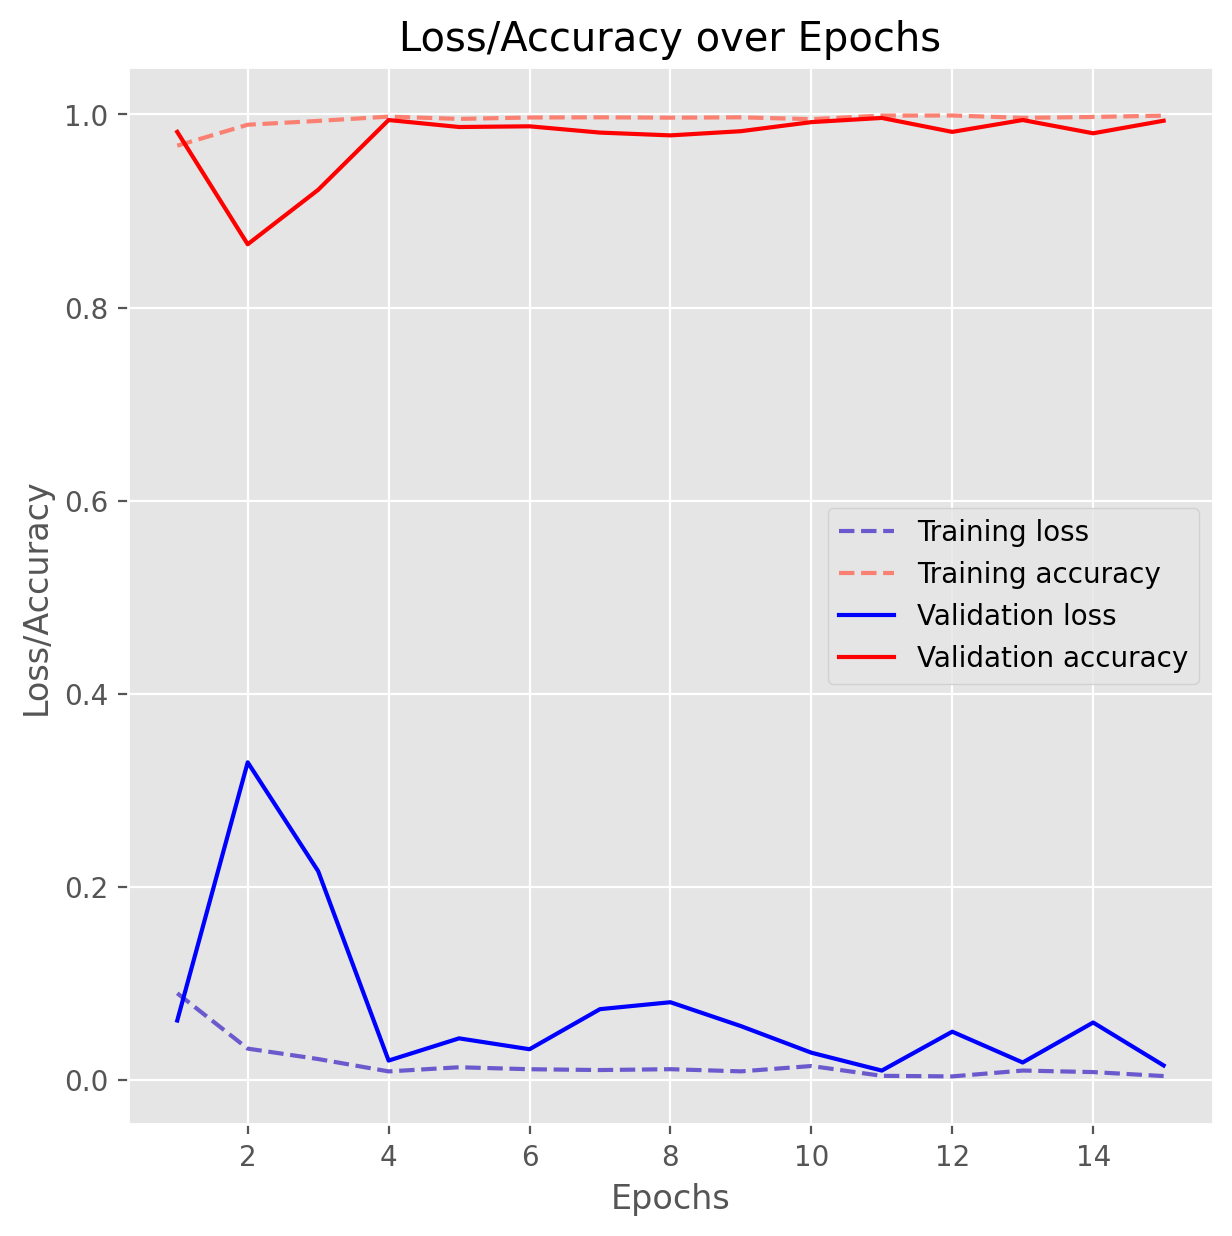

In [ ]:
plt.style.use('ggplot')

# loss and accuracy
epochs = list(range(1, len(history['train_loss'])+1))

plt.figure(figsize=(7,7), dpi=200)
plt.plot(epochs, history['train_loss'], c='slateblue', label='Training loss', linestyle='--')
plt.plot(epochs, history['train_acc'], c='salmon', label='Training accuracy', linestyle='--')
    
plt.plot(epochs, history['val_loss'], c='blue', label='Validation loss')
plt.plot(epochs, history['val_acc'], c='red', label='Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')

#plt.xlim(1, epochs[-1])
#plt.ylim(0,1)
plt.legend()
plt.title('Loss/Accuracy over Epochs')

plt.savefig('/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/loss_acc.pdf')

# Testing

If we want to test the model, we can load the saved model that we already trained:

In [48]:
def load_model(model_path):
    # instantiate the model
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 2))
    model = model.to(device)

    # load the trained model weights
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    print('model loaded successfully!')

    return model


save_path = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/model.pt'

model = load_model(save_path)

model loaded successfully!


In [49]:
model.eval()

true_labels = []
predictions = []

with torch.no_grad():
    loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        true_labels.append(labels)
        predictions.append(preds)

    true_labels = np.concatenate(true_labels)
    predictions = np.concatenate(predictions)

100%|██████████| 22/22 [00:09<00:00,  2.31it/s]


We'll make a confusion matrix, which is really helpful when it comes to visualizing how many labels were classified in each class:

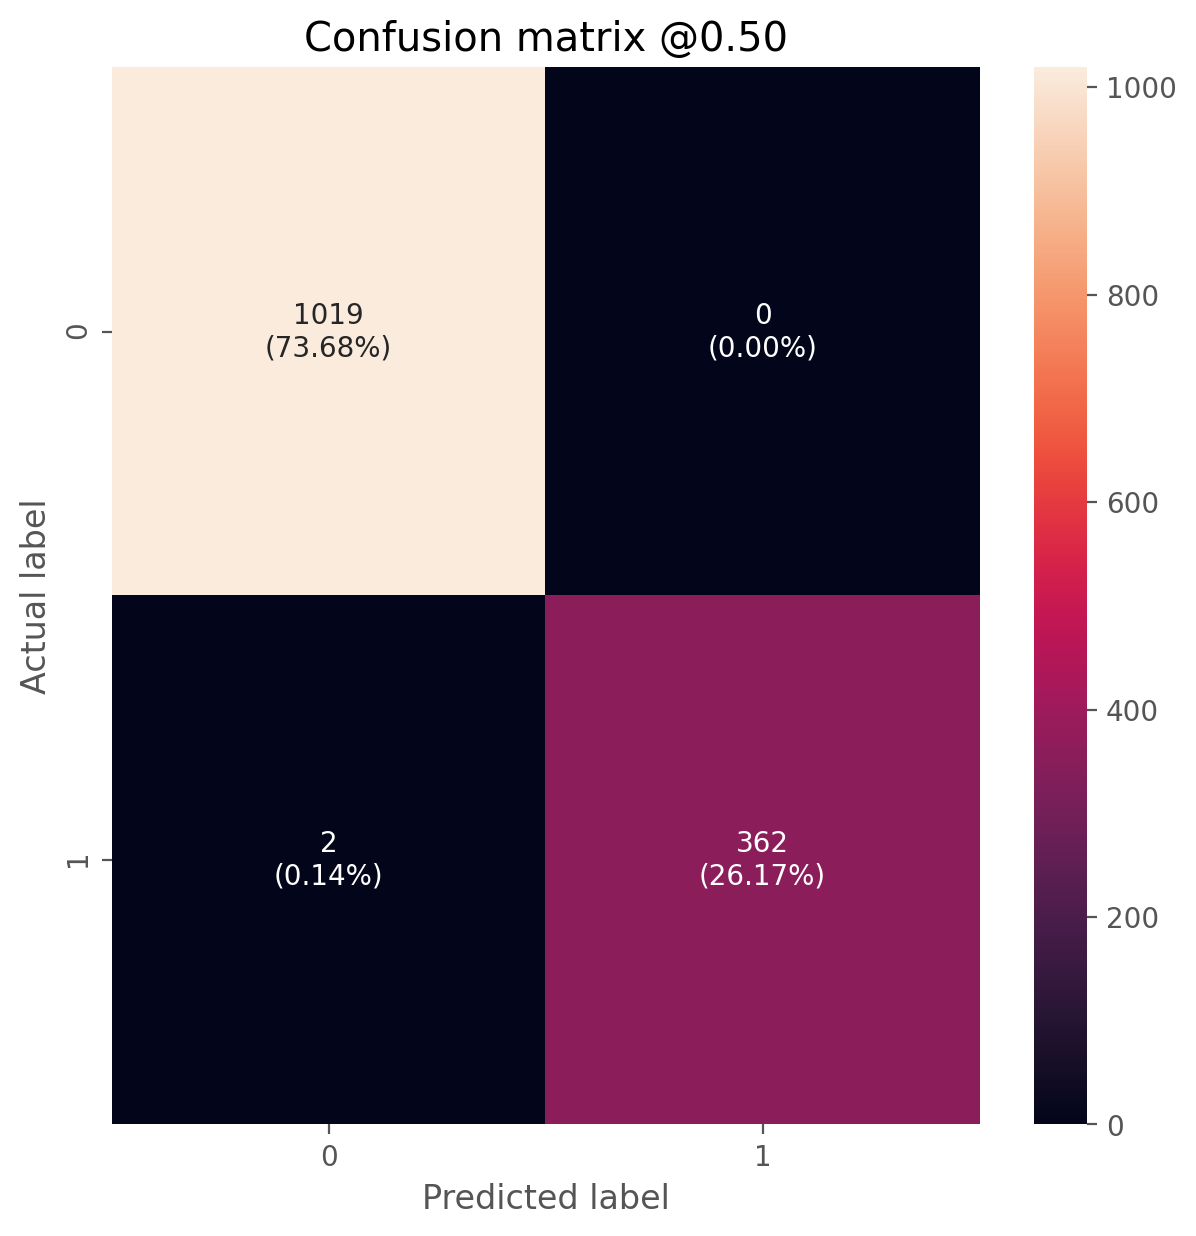

In [50]:
cm_path = '/content/drive/Shareddrives/GFC - Grupo de Física Computacional/Datathon2021/cm.pdf'

p = 0.5
cm = confusion_matrix(true_labels, predictions > p)
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
tn, fp, fn, tp = cm.ravel()
        
plt.figure(figsize=(7,7), dpi=200)
sns.heatmap(cm, annot=labels, fmt="")
plt.title('Confusion matrix @{:.2f}'.format(p))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig(cm_path)